In [19]:
## setup 

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns


#author : steeve laquitaine modified from everett wetchler
#purpose Helpers functions to check dataset
#Helper functions

def percentify_axis(ax, which):
    which = which.lower()
    if which in ('x', 'both'):
        ax.set_xticklabels(['%.0f%%' % (t*100) for t in ax.get_xticks()])
    if which in ('y', 'both'):
        ax.set_yticklabels(['%.0f%%' % (t*100) for t in ax.get_yticks()])

color_idx = 0
CYCLE_COLORS = sns.color_palette()
def next_color():
    global color_idx
    c = CYCLE_COLORS[color_idx] 
    color_idx = (color_idx + 1) % len(CYCLE_COLORS)
    return c

def count_unique(s):
    values = s.unique()
    return sum(1 for v in values if pd.notnull(v))

def missing_pct(s,N):
    missing = N - s.count()
    return missing * 100.0 / N

def complete_pct(s,N):
    return 100 - missing_pct(s,N)

def summarize_completeness_uniqueness(df,N):
    print '*** How complete is each feature? How many different values does it have? ***'
    rows = []
    for col in df.columns:
        rows.append([col, '%.0f%%' % complete_pct(df[col],N), count_unique(df[col])])
    dframe = pd.DataFrame(rows, columns=['Column Name', 'Complete (%)','Unique Values'])
    pd.set_option('display.max_colwidth',999,'display.max_row',999)
    return dframe

def summarize_completeness_over_time(df, time_col, transpose=True):
    print '*** Data completeness over time per column ***'
    x = df.groupby(time_col).count()
    x = x.div(df.groupby(time_col).size(), axis=0)
    for col in x.columns:
        x[col] = x[col].apply(lambda value: '%.0f%%' % (value * 100))
    if transpose:
        return x.T
    pd.set_option('display.max_colwidth',999,'display.max_row',999)
    return x

def plot_top_hist(df, col, top_n=10, skip_below=.01):
    '''Plot a histogram of a categorical dataframe column, limiting to the most popular.'''
    counts = df[col].value_counts(True, ascending=True)
    if counts.max() < skip_below:
        print 'Skipping "%s" histogram -- most common value is < %.0f%% of all cases' % (col, skip_below*100)
        return
    fig, ax = plt.subplots(1)
    explanation = ''
    if len(counts) > top_n:
        explanation = ' (top %d of %d)' % (top_n, len(counts))
        counts = counts.iloc[-top_n:]
    explanation += ' -- %.0f%% missing' % (missing_pct(df[col]))
    counts.plot(kind='barh', ax=ax, color=next_color())
    ax.set_title('Rows by "%s"%s' % (col, explanation))
    ax.set_xticklabels(['%.0f%%' % (t*100) for t in ax.get_xticks()])

%matplotlib inline

# Useful colors to reference
SNS_BLUE, SNS_GREEN, SNS_RED, SNS_PURPLE, SNS_YELLOW, SNS_CYAN = sns.color_palette()
# sns.set_palette(sns.color_palette("cubehelix", 8))
pd.set_option('display.max_columns', 500)
plt.rcParams.update({
  'font.size': 14,
  'axes.titlesize': 'x-large',
  'axes.labelsize': 'large',
  'xtick.labelsize': 'medium',
  'ytick.labelsize': 'medium',
  'legend.fancybox': True,
  'legend.fontsize': 'medium',
  'legend.frameon': True,
  'legend.framealpha': 0.7,
  'figure.figsize': ['9', '6'],
})

print "Complete"

Complete


In [3]:
## import data 
infile = "/Users/alysonkane/Desktop/HHS/health-insurance-marketplace/BusinessRules.csv"

df = pd.read_csv(infile)
N = len(df)
print 'Read %d rows %d cols\n' % df.shape 
df.head(5)


Read 21085 rows 23 cols



,BusinessYear,StateCode,IssuerId,SourceName,VersionNum,ImportDate,IssuerId2,TIN,ProductId,StandardComponentId,...,DependentMaximumAgRule,ChildrenOnlyContractMaxChildrenRule,DomesticPartnerAsSpouseIndicator,SameSexPartnerAsSpouseIndicator,AgeDeterminationRule,MinimumTobaccoFreeMonthsRule,CohabitationRule,RowNumber,MarketCoverage,DentalOnlyPlan
0,2014,AL,82285,HIOS,7,2014-01-21 08:29:49,82285,94-2761537,NaN,82285AL0010006,...,26,3 or more,Yes,Yes,Age on effective date,Not Applicable,"Spouse,No;Adopted Child,No;Foster Child,No;War...",14,NaN,NaN
1,2014,AL,82285,HIOS,7,2014-01-21 08:29:49,82285,94-2761537,NaN,82285AL0020001,...,Not Applicable,3 or more,Yes,Yes,Age on effective date,Not Applicable,"Adopted Child,Yes;Foster Child,Yes;Stepson or ...",15,NaN,NaN
2,2014,AL,82285,HIOS,7,2014-01-21 08:29:49,82285,94-2761537,NaN,82285AL0020002,...,Not Applicable,3 or more,Yes,Yes,Age on effective date,Not Applicable,"Adopted Child,Yes;Foster Child,Yes;Stepson or ...",16,NaN,NaN
3,2014,AL,82285,HIOS,7,2014-01-21 08:29:49,82285,94-2761537,NaN,82285AL0020004,...,26,3 or more,Yes,Yes,Age on effective date,Not Applicable,"Spouse,No;Adopted Child,No;Foster Child,No;War...",17,NaN,NaN
4,2014,AL,82285,HIOS,7,2014-01-21 08:29:49,82285,94-2761537,NaN,82285AL0020006,...,26,3 or more,Yes,Yes,Age on effective date,Not Applicable,"Spouse,No;Adopted Child,No;Foster Child,No;War...",18,NaN,NaN


In [7]:
## remove duplicated fields 
df_cleaned = df
print sum(df_cleaned['IssuerId']==df_cleaned['IssuerId2'])*100/N,'% of the rows match between "IssuerId" and "IssuerId2" so "IssuerId2" was removed.'
df_cleaned = df_cleaned.drop('IssuerId2',1)
print 'Read %d rows %d cols\n' % df_cleaned.shape 

100 % of the rows match between "IssuerId" and "IssuerId2" so "IssuerId2" was removed.
Read 21085 rows 22 cols



In [8]:
## summarize data 
summarize_completeness_uniqueness(df_cleaned,N)

*** How complete is each feature? How many different values does it have? ***


,Column Name,Complete (%),Unique Values
0,BusinessYear,100%,3
1,StateCode,100%,39
2,IssuerId,100%,910
3,SourceName,100%,3
4,VersionNum,100%,23
5,ImportDate,100%,268
6,TIN,100%,343
7,ProductId,92%,3034
8,StandardComponentId,95%,14189
9,EnrolleeContractRateDeterminationRule,99%,2


In [10]:
## variables with expected values
VarWithExpecVals = ['BusinessYear','StateCode','IssuerId','SourceName', 'EnrolleeContractRateDeterminationRule',
                    'TwoParentFamilyMaxDependentsRule', 'SingleParentFamilyMaxDependentsRule',
                    'ChildrenOnlyContractMaxChildrenRule', 'DomesticPartnerAsSpouseIndicator', 'SameSexPartnerAsSpouseIndicator',
                    'AgeDeterminationRule','MarketCoverage','DentalOnlyPlan']

## expected values
expectedVals = {}
expectedVals["BusinessYear"] = [2014,2015,2016]
expectedVals["StateCode"] = ['AK','AL','AZ','AR','CA','CO','CT','DE','FL','GA','HI','ID','IL','IN','IA','KS','KY','LA','ME','MD','MA','MI','MN','MS','MO','MT','NE','NV','NH','NJ','NM','NY','NC','ND','OH','OK','OR','PA','RI','SC','SD','TN','TX','UT','VT','VA','WA','WV','WI','WY']
expectedVals["IssuerId"] = np.arange(99999)
expectedVals["SourceName"] = ['HIOS','SERFF','OPM']
expectedVals["EnrolleeContractRateDeterminationRule"] = ['There are rates specifically for couples and for families (not just addition of individual rates)',
                                                         'A different rate (specifically for parties of two or more) for each enrollee is added together']
expectedVals["TwoParentFamilyMaxDependentsRule"] = ['1','2','3 or more']
expectedVals["SingleParentFamilyMaxDependentsRule"] = ['1','2','3 or more']
expectedVals["ChildrenOnlyContractMaxChildrenRule"] = ['1','2','3 or more']
expectedVals["DomesticPartnerAsSpouseIndicator"] = ['Yes', 'No']
expectedVals["SameSexPartnerAsSpouseIndicator"] = ['Yes','No'] 
expectedVals["AgeDeterminationRule"] = ['Age on effective date','Age on January 1st of the effective date year',
                                        'Age on insurance date (age on birthday nearest the effective date)','Age on January 1st or July 1st']
expectedVals["MarketCoverage"] = ['Individual','SHOP (Small Group)']
expectedVals["DentalOnlyPlan"] = ['Yes','No']



print '*** Are there any values outside their expected range ? ***'
rows = []

#Check validity
for col in VarWithExpecVals:    
    #check among existing values    
    s = pd.Series(list(df[col]))            
    s_exist = s[pd.notnull(s)]
    numValid = np.sum(s_exist.isin(expectedVals[col]))    
    percValid = numValid*100/len(s_exist)
    rows.append([col,'%.0f%%' % percValid,numValid])
tab = pd.DataFrame(rows,columns=['Column Name', 'Valid value(%)','Unique Valid Values'])

#fill up cleaned dataset
for col in VarWithExpecVals:    
    df_cleaned[col] = df[col]
    
tab  

*** Are there any values outside their expected range ? ***


,Column Name,Valid value(%),Unique Valid Values
0,BusinessYear,100%,21085
1,StateCode,100%,21085
2,IssuerId,100%,21085
3,SourceName,100%,21085
4,EnrolleeContractRateDeterminationRule,9%,2011
5,TwoParentFamilyMaxDependentsRule,100%,20546
6,SingleParentFamilyMaxDependentsRule,100%,20546
7,ChildrenOnlyContractMaxChildrenRule,100%,20416
8,DomesticPartnerAsSpouseIndicator,100%,20575
9,SameSexPartnerAsSpouseIndicator,100%,20575


In [14]:
## Check yes/no values are all formatted similarly 

print (pd.unique(df["DomesticPartnerAsSpouseIndicator"]))
print (pd.unique(df["SameSexPartnerAsSpouseIndicator"]))
print (pd.unique(df["DentalOnlyPlan"]))


['Yes' 'No' nan]
['Yes' 'No' nan]
[nan 'Yes' 'No']


In [15]:
summarize_completeness_over_time(df_cleaned,'ImportDate')

*** Data completeness over time per column ***


ImportDate,2013-06-04 08:25:28,2013-06-05 12:49:14,2013-06-06 10:50:48,2013-06-07 09:05:04,2013-06-28 08:36:25,2013-07-01 08:34:30,2013-07-01 22:22:31,2013-07-02 22:25:47,2013-07-23 22:50:01,2013-07-31 07:05:07,...,2015-11-16 09:33:51,2015-11-17 13:45:28,2015-11-17 16:15:02,2015-11-17 22:52:32,2015-11-18 07:25:09,2015-11-18 10:26:26,2015-11-18 13:05:03,2015-11-19 07:02:40,2015-11-19 15:13:16,2015-11-21 06:31:07
BusinessYear,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%,...,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%
StateCode,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%,...,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%
IssuerId,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%,...,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%
SourceName,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%,...,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%
VersionNum,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%,...,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%
TIN,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%,...,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%
ProductId,0%,0%,9%,0%,0%,14%,0%,0%,0%,25%,...,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%
StandardComponentId,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,...,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%
EnrolleeContractRateDeterminationRule,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%,...,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%
TwoParentFamilyMaxDependentsRule,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%,...,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%


In [16]:
print 'Read %d rows %d cols\n' % df_cleaned.shape 

Read 21085 rows 22 cols



#### 25 is the most frequent max dependency age amongst plans 

The dataset contains plans for 39 of the 50 US states


/Users/alysonkane/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


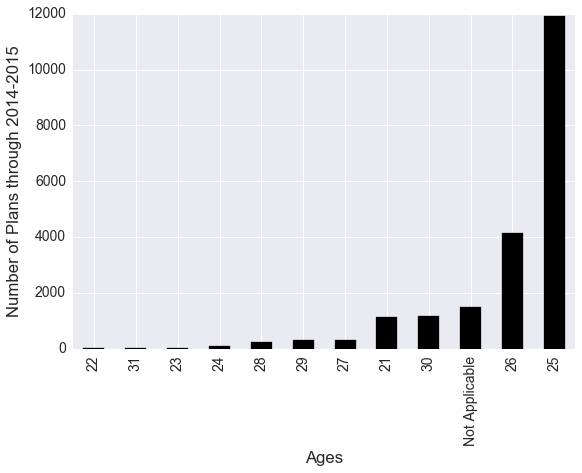

In [24]:
a = df_cleaned.groupby('DependentMaximumAgRule').agg(['count']);
a['BusinessYear'].sort('count').plot(kind='bar',color='k',legend=False);
plt.xlabel('Ages');
plt.ylabel('Number of Plans through 2014-2015');

/Users/alysonkane/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


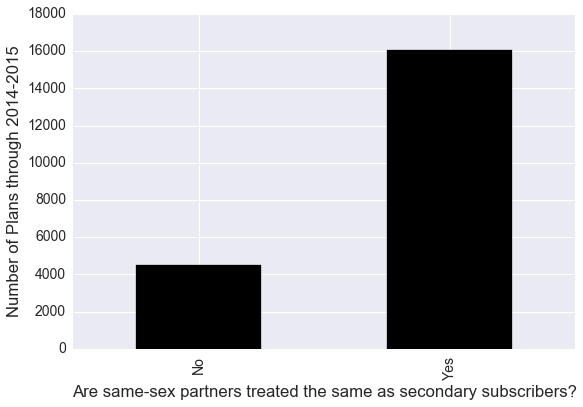

In [26]:
a = df_cleaned.groupby('SameSexPartnerAsSpouseIndicator').agg(['count']);
a['BusinessYear'].sort('count').plot(kind='bar',color='k',legend=False);
plt.xlabel('Are same-sex partners treated the same as secondary subscribers?');
plt.ylabel('Number of Plans through 2014-2015');

In [27]:
df_cleaned.to_csv('/Users/alysonkane/Desktop/HHS/health-insurance-marketplace/BusinessRules_clean.csv')